# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [3]:
# Image Pre-Processing

In [4]:
def minmaxScaler_scal(x,Max=2,Min=1,types=None):
    x_std=((x-x.min())/ (x.max())- x.min())
    
    x=x_std * (Max- Min)+Min
    print(x)
    return x

In [5]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input , MobileNetV2
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            #rescale=1./255.0, # 0 : 1
            #preprocessing_function=minmaxScaler_scal,
            preprocessing_function=preprocess_input,
            rotation_range=10,
            horizontal_flip=True,
            vertical_flip=True,
            validation_split = 0.1
            )

In [6]:
train_generator = datagen.flow_from_directory(
            directory="../input/dataset/train",
            subset="training",
            batch_size=64,
            #color_mode='grayscale',
            seed=42,
            shuffle=True,
            class_mode="binary",
            target_size=(64,64))

Found 4452 images belonging to 2 classes.


In [7]:
list(train_generator.class_indices.keys())

['Normal', 'OSCC']

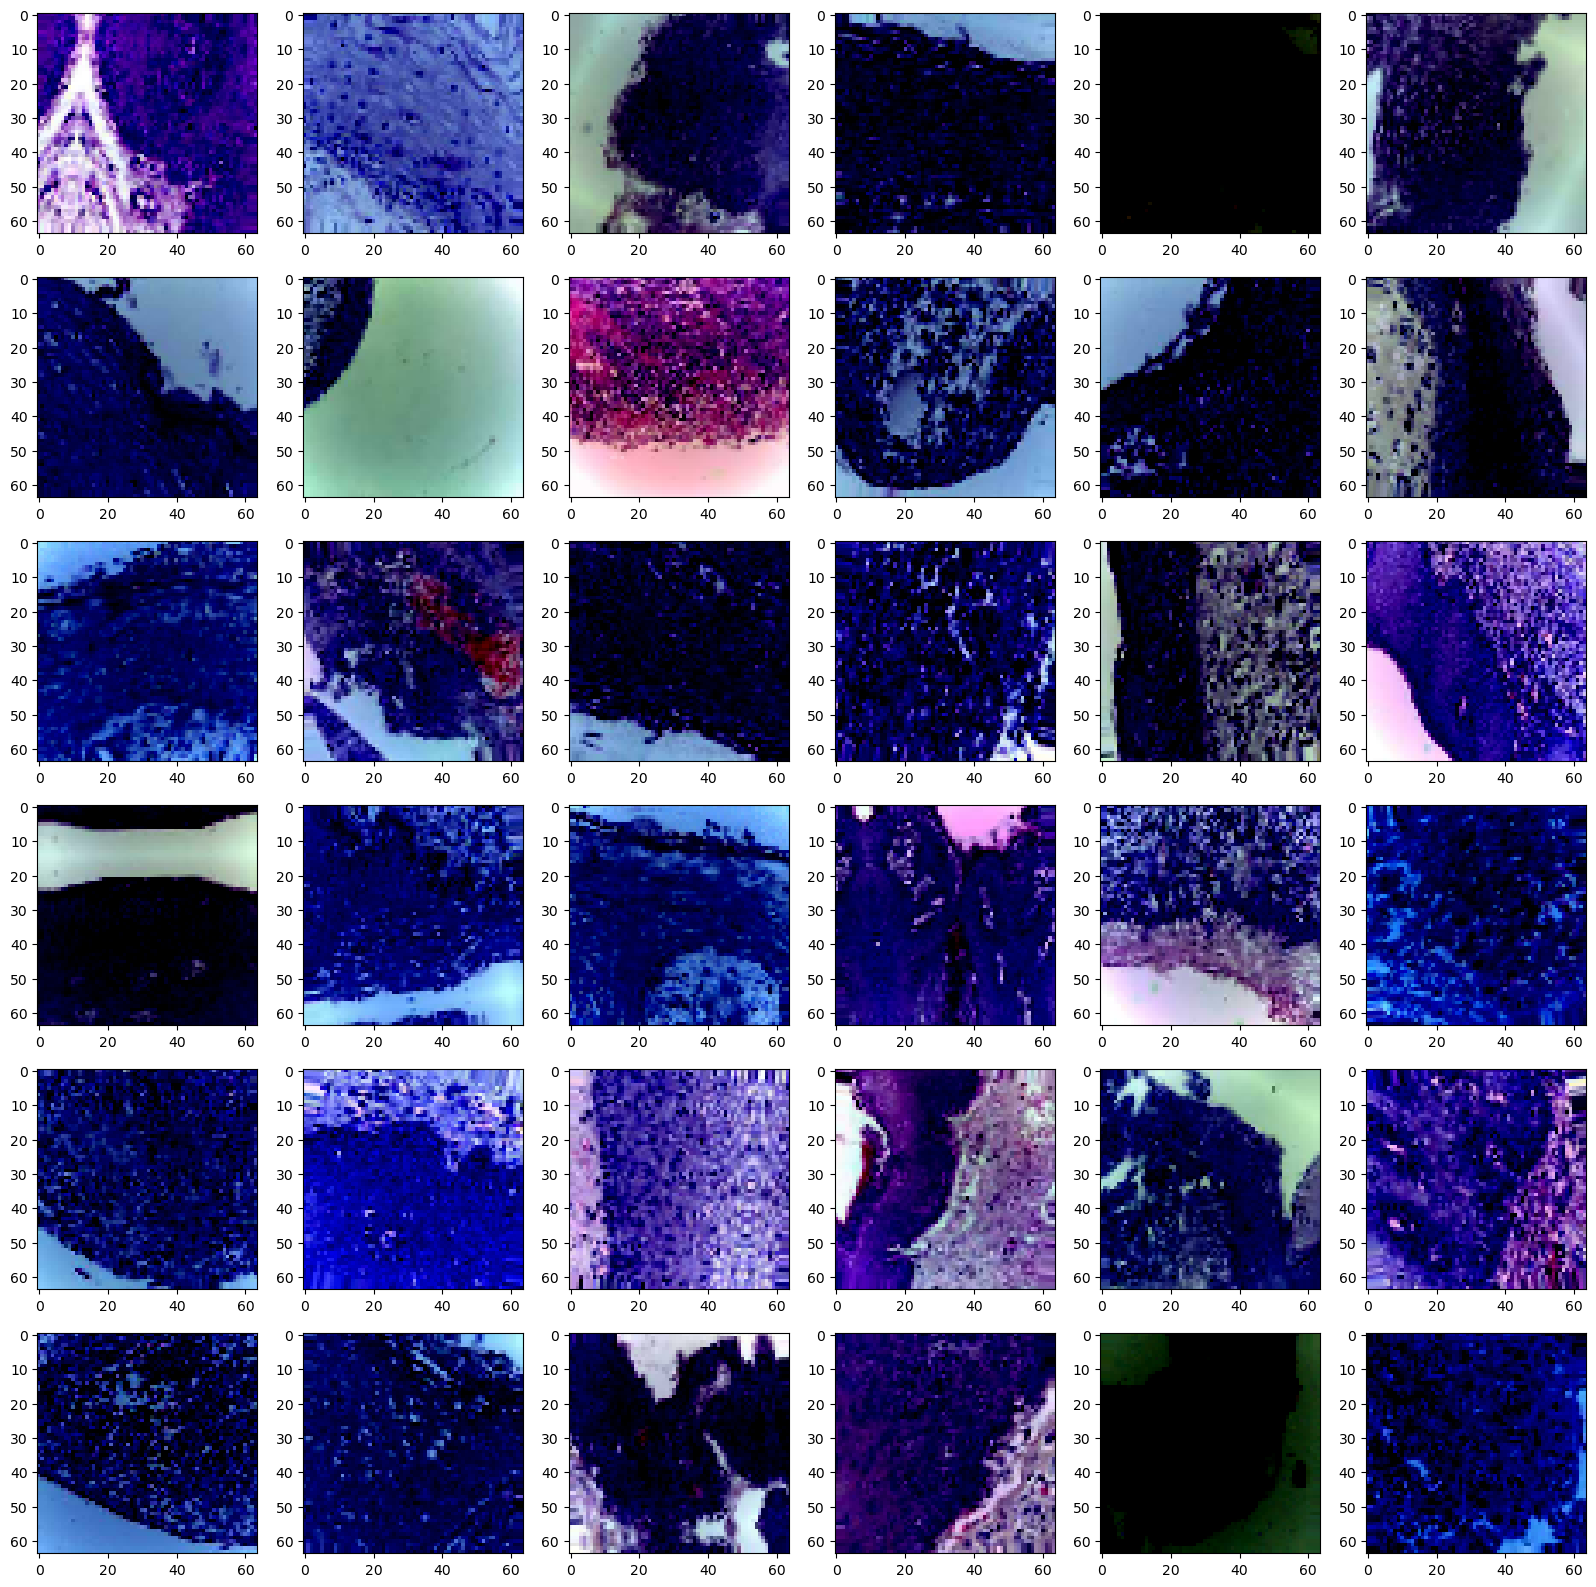

In [8]:
classes=list(train_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0,36):
        plt.subplot(6,6,i+1)
        plt.imshow(X_batch[i])
    # show the plot
    plt.show()
    break

In [9]:
datagen_valid = tf.keras.preprocessing.image.ImageDataGenerator(
            #rescale=1./255.,
            preprocessing_function=preprocess_input,
            validation_split = 0.1
            )

In [10]:
valid_generator = datagen_valid.flow_from_directory(
            directory="../input/dataset/train",
            subset="validation",
            batch_size=64,
            seed=42,
            shuffle=False,
            class_mode="binary",
            target_size=(64,64))

Found 494 images belonging to 2 classes.


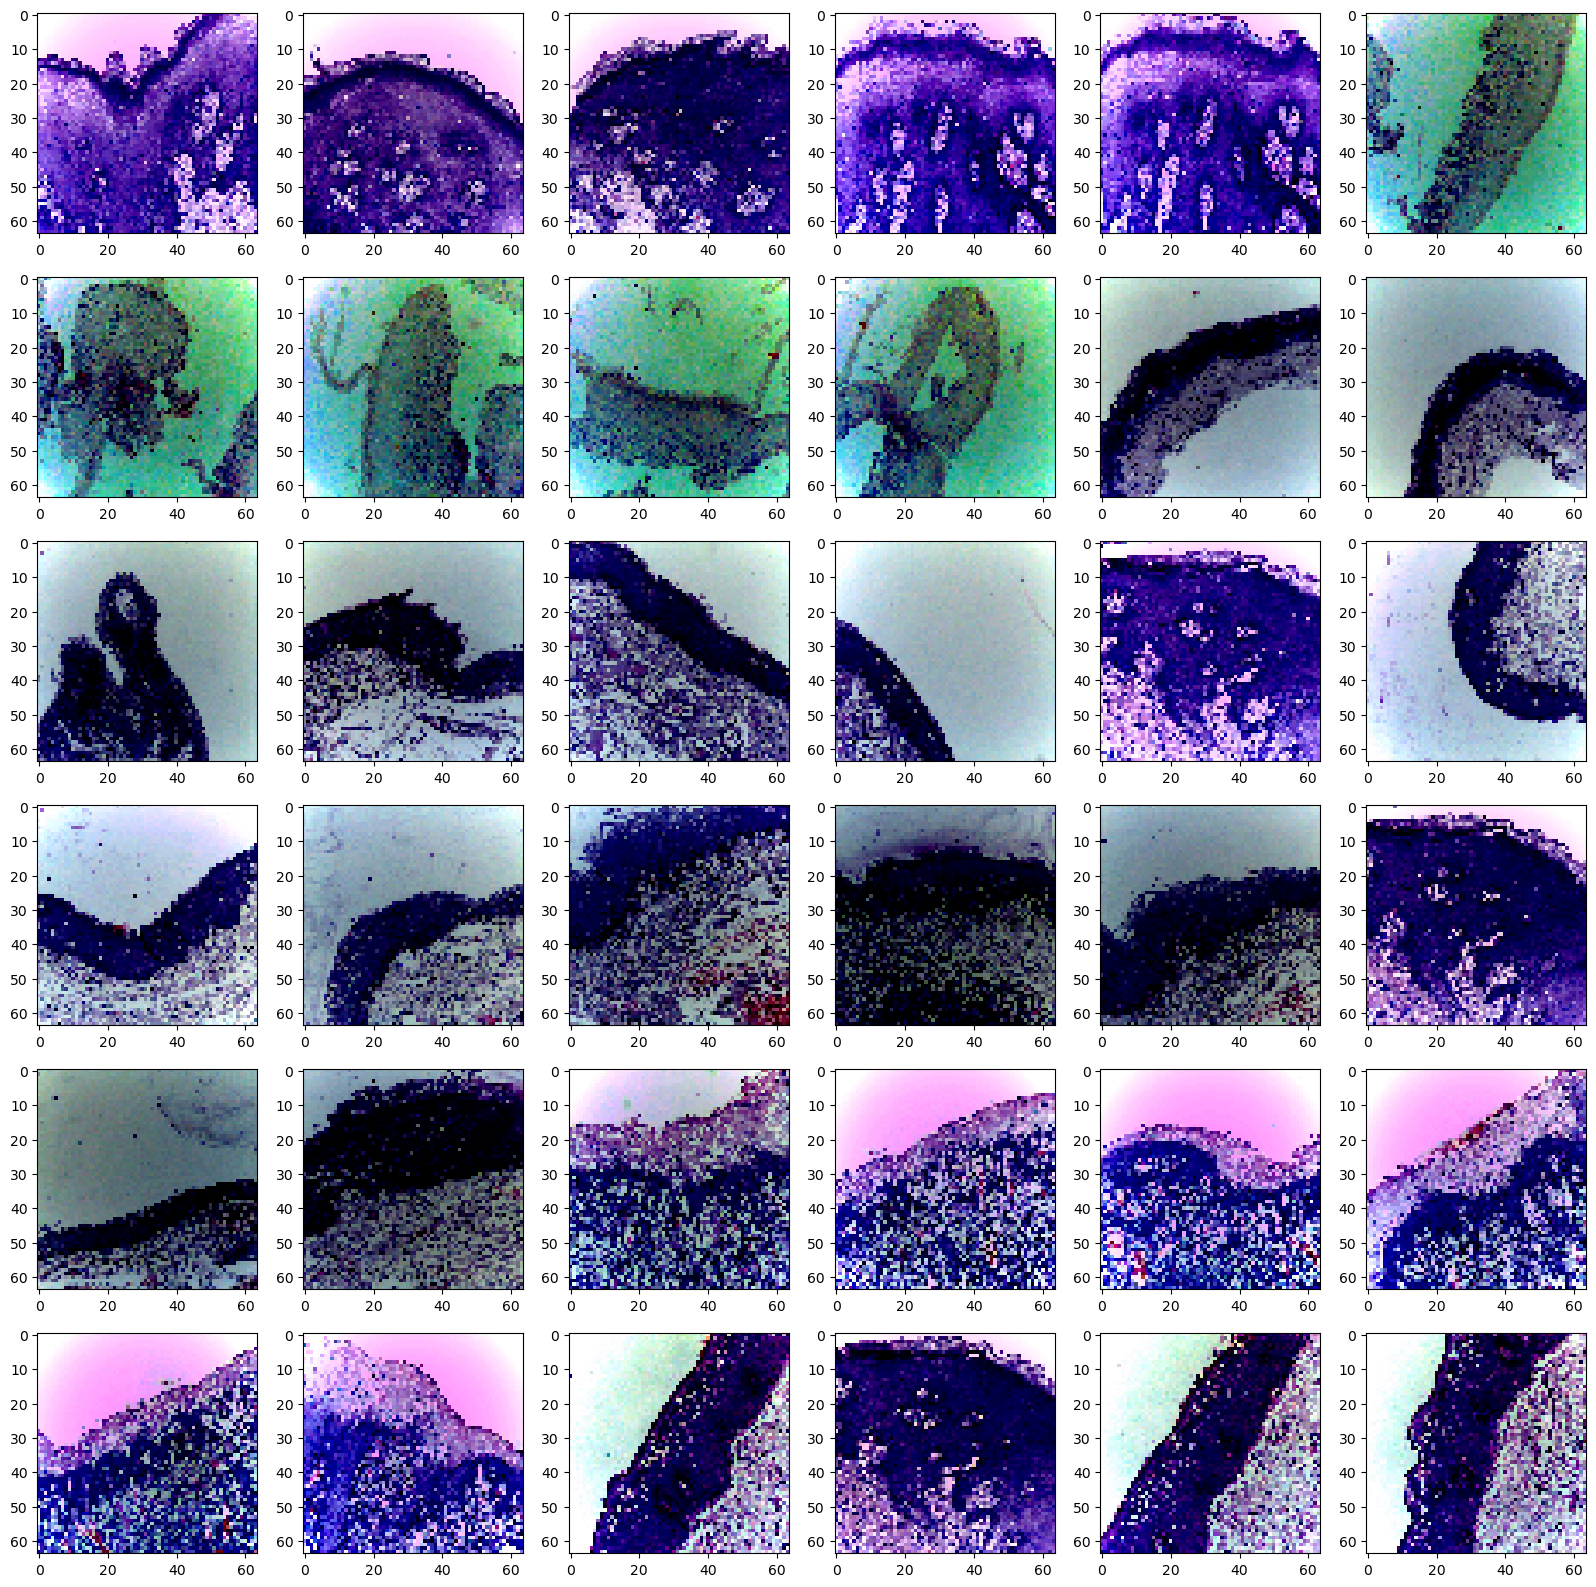

In [11]:
plt.figure(figsize=(20,20))
for X_batch, y_batch in valid_generator:
    # create a grid of 3x3 images
    for i in range(0,36):
        plt.subplot(6,6,i+1)
        plt.imshow(X_batch[i])
    # show the plot
    plt.show()
    break

In [12]:
datagen_test = tf.keras.preprocessing.image.ImageDataGenerator(
            #rescale=1./255.
    preprocessing_function=preprocess_input,
            )

In [13]:
test_generator = datagen_test.flow_from_directory(
            directory="../input/dataset/test",
            batch_size=64,
            seed=42,
            shuffle=False,
            class_mode="binary",
            target_size=(64,64))

Found 126 images belonging to 2 classes.


In [ ]:
plt.figure(figsize=(20,20))
for X_batch, y_batch in test_generator:
    # create a grid of 3x3 images
    for i in range(0,36):
        plt.subplot(6,6,i+1)
        plt.imshow(X_batch[i])
        plt.grid(visible=None)
    # show the plot
    plt.show()
    break

# Model Creation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization ,GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

In [ ]:
#optimizer
optimizer_adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99)

In [ ]:
#callbacks

# EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
# callback=[EarlyStop , Reduce_LR,model_check]

In [ ]:
'''model=Sequential([
                  Conv2D(64,3,activation='relu',kernel_initializer='he_normal',input_shape=(64,64,3)),
                  BatchNormalization(),
                  Conv2D(128,3,activation='relu',kernel_initializer='he_normal'),
                  BatchNormalization(),
                  MaxPooling2D(3),
                  Conv2D(256,3,activation='relu'),
                  BatchNormalization(),
                  MaxPooling2D(3),
                  Conv2D(512,3,padding='valid',activation='relu'),
                  BatchNormalization(),
                  GlobalMaxPool2D(),
                  Flatten(),
                  Dense(512,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                  BatchNormalization(),
                  Dense(1024,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                  BatchNormalization(),
                  Dense(1,activation='sigmoid',kernel_initializer='glorot_normal')
                  
])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])'''

In [ ]:
from tensorflow.keras.applications.inception_v3 import preprocess_input , InceptionV3

In [ ]:
vgg=InceptionV3(weights='/kaggle/input/weights/inception_v3_weights_tf_dim_ordering_tf_kernels.h5')

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input , MobileNetV2

In [ ]:
Mb=MobileNetV2(include_top=False,weights='/kaggle/input/weights2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5',input_shape=(64,64,3))

In [ ]:
Mb.summary()

In [ ]:
Mb.trainable=False

# Model Compilation

In [ ]:
model=Sequential([
                  Mb,
                  Flatten(),
                  Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                  BatchNormalization(),
                  Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
                  BatchNormalization(),
                  Dense(1,activation='sigmoid',kernel_initializer='glorot_normal')
                  
])

model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

# Model Training

In [ ]:
history=model.fit(train_generator,validation_data=valid_generator,epochs=10,
                  steps_per_epoch=len(train_generator)//16,validation_steps=len(valid_generator)//8,
#                   callbacks=callback, 
                  verbose=1)


In [ ]:
model.evaluate(test_generator)

In [ ]:
#plotting training values
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
predictions = model.predict(test_generator)


In [ ]:
predictions[0:5]

In [ ]:
test_generator.classes

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_generator.classes, predictions.round())

sns.heatmap(cm,  annot=True, fmt="d" ,cmap="YlGnBu")

# Model Evaluation

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, predictions.round())) #.argmax(axis=-1)

In [ ]:
from tensorflow.keras.preprocessing import image

# Model Prediction

In [ ]:
img=plt.imread('/kaggle/input/dataset/test/OSCC/OSCC_100x_350.jpg')
img.shape

In [ ]:
img=cv2.resize(img,(64,64))

In [ ]:
img.shape

In [ ]:
image = np.expand_dims(img,axis=0) 

In [ ]:
image.shape

In [ ]:
ypred = model.predict(image)

In [ ]:
if ypred<0.5:
      ypred="Normal"
else:
      ypred="Squamous Cell Carcinoma" 
plt.imshow(img)
ypred